# Recursive multi-step forecasting

Since the value of $t_{n-1}$ is required to predict $t_{n}$, and $t_{n-1}$ is unknown, a recursive process is applied in which, each new prediction, is based on the previous one. This process is known as recursive forecasting or recursive multi-step forecasting.

<p align="center"><img src="../img/diagram-recursive-mutistep-forecasting.png" style="width: 650px"></p>

The major challenge when using machine learning models for recursive multi-step forecasting is transforming the time series into a matrix where each value of the series is related to the time window (lags) that precedes it. This forecasting strategy can be easily generated with the classes `ForecasterAutoreg` and `ForecasterAutoregCustom`.

<center><img src="../img/forecasting_multi-step_en.gif" style='width: 600px' align='center'></center>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

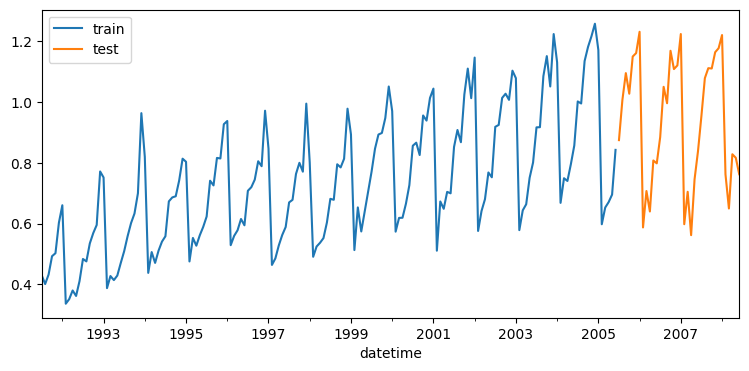

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Train forecaster

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-03-08 14:23:40 
Last fit date: 2023-03-08 14:23:40 
Skforecast version: 0.7.0 
Python version: 3.9.13 
Fore

## Prediction

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=36)
predictions.head(3)

2005-07-01    0.921840
2005-08-01    0.954921
2005-09-01    1.101716
Freq: MS, Name: pred, dtype: float64

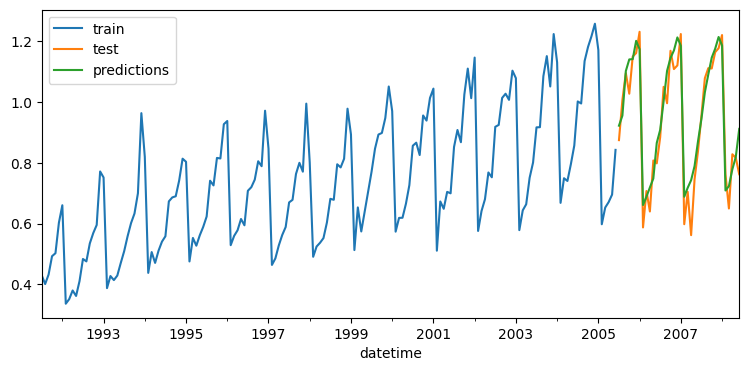

In [5]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00429855684785846


## Prediction intervals

A prediction interval defines the interval within which the true value of `y` is expected to be found with a given probability. For example, the prediction interval (1, 99) can be expected to contain the true prediction value with 98% probability.

By default, every forecaster can estimate prediction intervals using the method `predict_interval`. For a detailed explanation of the different prediction intervals available in skforecast visit [Prediction intervals](https://joaquinamatrodrigo.github.io/skforecast/latest/notebooks/prediction-intervals.html).

In [7]:
# Predict intervals
# ==============================================================================
predictions = forecaster.predict_interval(steps=36, interval=[5, 95], n_boot=100)
predictions.head(3)

pred  lower_bound  upper_bound
2005-07-01  0.921840     0.884362     0.960898
2005-08-01  0.954921     0.923163     0.980901
2005-09-01  1.101716     1.057791     1.143083

## Feature importance

In [8]:
forecaster.get_feature_importance()

feature  importance
0    lag_1    0.012340
1    lag_2    0.085160
2    lag_3    0.013407
3    lag_4    0.004374
4    lag_5    0.003188
5    lag_6    0.003436
6    lag_7    0.003136
7    lag_8    0.007141
8    lag_9    0.007831
9   lag_10    0.012751
10  lag_11    0.009019
11  lag_12    0.807098
12  lag_13    0.004811
13  lag_14    0.016328
14  lag_15    0.009979

## Extract training matrix

In [9]:
X, y = forecaster.create_train_X_y(data_train)
X.head()

lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
datetime                                                                 
1992-10-01  0.534761  0.475463  0.483389  0.410534  0.361801  0.379808   
1992-11-01  0.568606  0.534761  0.475463  0.483389  0.410534  0.361801   
1992-12-01  0.595223  0.568606  0.534761  0.475463  0.483389  0.410534   
1993-01-01  0.771258  0.595223  0.568606  0.534761  0.475463  0.483389   
1993-02-01  0.751503  0.771258  0.595223  0.568606  0.534761  0.475463   

               lag_7     lag_8     lag_9    lag_10    lag_11    lag_12  \
datetime                                                                 
1992-10-01  0.351348  0.336220  0.660119  0.602652  0.502369  0.492543   
1992-11-01  0.379808  0.351348  0.336220  0.660119  0.602652  0.502369   
1992-12-01  0.361801  0.379808  0.351348  0.336220  0.660119  0.602652   
1993-01-01  0.410534  0.361801  0.379808  0.351348  0.336220  0.660119   
1993-02-01  0.483389  0.410534  0.361801  0.379808  0.351348  0.336220   

              lag_13    lag_14    lag_15  
datetime                                  
1992-10-01  0.432159  0.400906  0.429795  
1992-11-01  0.492543  0.432159  0.400906  
1992-12-01  0.502369  0.492543  0.432159  
1993-01-01  0.602652  0.502369  0.492543  
1993-02-01  0.660119  0.602652  0.502369

In [10]:
y.head()

datetime
1992-10-01    0.568606
1992-11-01    0.595223
1992-12-01    0.771258
1993-01-01    0.751503
1993-02-01    0.387554
Freq: MS, Name: y, dtype: float64

In [11]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>